# Фінальний проект. Основи машинного навчання.

## Завдання.
Побудувати модель бінарної класифікації.

## Виконання.

Робота виконувалася ітеративно, постійно змінювалися підходи до підготовки даних. Було випробувано велику кількість моделей з базовими метапараметрами.
Алгоритим дій, що описаний в даній роботі - це один за найпростіших підходів у поєднанні з найкращими показники метрики `balanced_accuracy_score`.

Підходи до підготовки даних, що були протестовані, але були виключені:

1. Видалення всіх Пропущених значень.
2. Заповнення пропусків в категоріальних ознаках модою.
3. Різні види скейлерів для числових ознак (наприклад `MinMaxScaler`, `RobustScaler`)
4. `KNNImputer` для заповнення пропусків.
5. `PolynomialFeatures` для числових ознак.
6. Та інше.

Список моделей, що були випробувані:

1. `PCA`
2. `RandomForestClassifier`
3. `GradientBoostingClassifier`
4. `HistGradientBoostingClassifier`
5. `LogisticRegression`
6. `SVC`
7. `CatBoostClassifier`
8. `LGBMClassifier`
9. `XGBClassifier`

### 1. Імпорт бібліотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn import set_config
set_config(transform_output="pandas")

### 2. Кілька функцій для зручного перевикористання шматків коду.

In [2]:
def load_train():
    return pd.read_csv('./datasets/final_proj_data.csv')

def load_test():
    return pd.read_csv('./datasets/final_proj_test.csv')

def write_submission(y_pred, filename='./datasets/submission.csv'):
    df = pd.DataFrame({'y': y_pred})
    df.index.name = 'index'
    df.to_csv(filename)

def get_num_cat(df):
    num = df.select_dtypes(include=np.number)
    cat = df.select_dtypes(include='object')
    return num, cat

### 3. Аналіз даних.

In [3]:
Xy = load_train()

y = Xy.y
X = Xy.drop(columns=['y'])

lines_num, columns_num = X.shape

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 17.5+ MB


Як бачимо, у нас 192 колонки числові, і 38 - типу `object`.

Аналізуємо базові статистичні дані нашого датасету, щоб отримати хоча б якесь уявлення про характер числових значень.

In [5]:
descr = X.describe().T
descr

,count,mean,std,min,25%,50%,75%,max
Var1,133.0,14.977444,66.456008,0.0,0.000,0.00,16.000,680.00
Var2,266.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.00
Var3,266.0,341.052632,2810.606975,0.0,0.000,0.00,0.000,42588.00
Var4,280.0,0.096429,0.928243,0.0,0.000,0.00,0.000,9.00
Var5,241.0,233810.124481,553230.515446,0.0,0.000,0.00,117235.000,3024000.00
...,...,...,...,...,...,...,...,...
Var188,266.0,159.107368,115.766972,0.0,18.840,194.67,247.080,452.76
Var189,4206.0,272.455064,86.752531,6.0,204.000,270.00,330.000,642.00
Var190,43.0,25725.112326,37487.484852,0.0,1312.875,10853.82,37491.525,191167.20
Var209,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Перевіряємо, що ми не маємо пропусків в цільовій змінній.

In [6]:
y.info(), y.sum()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: y
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.3 KB


(None, 1305)

Оцінюємо наявні пропуски.

In [7]:
cnt = X.count()
num_column_info = pd.DataFrame({'empty'  : cnt == 0,
                                '0.2'    : cnt >= lines_num * 0.2,
                                '0.3'    : cnt >= lines_num * 0.3,
                                '0.4'    : cnt >= lines_num * 0.4,
                                '0.5'    : cnt >= lines_num * 0.5,
                                '0.6'    : cnt >= lines_num * 0.6,
                                '0.7'    : cnt >= lines_num * 0.7,
                                '0.8'    : cnt >= lines_num * 0.8,
                                '0.9'    : cnt >= lines_num * 0.9,
                                'full'   : cnt == lines_num,
                              })

num_column_info.sum()

empty    18
0.2      76
0.3      74
0.4      74
0.5      71
0.6      67
0.7      67
0.8      66
0.9      49
full     21
dtype: int64

Як бачимо, наш датасет має дуже багато пропусків. 18 ознак взагалі без жодних записів, лиш 67 ознак, що мають ступіть заповненості більше 70%, і лише 21 ознаку без жодних пропусків.

Маємо приймати до уваги, що заповнення такої великої кількості пропускім якимись значеннями скоріш за все призведе до викривлення моделі.
А отже було прийнято рішення спочатку отримати важливість кожної з ознак, при умові, що всі пропуски заповнені. Потім, видалити ознаки які мають критичний рівень пропусків, але при цьому, не видаляти ознаки, які мають високу важливість.
Оскільки цей процес був ітеративний (багаторазове виконання одного й того ж коду, але з різниною підготовкою даних), то далі опишу лиш основний алгоритм.
Також варто зауважити, що робити оцінку ознак важливо на таких даних, які максимально схожі на ті, що буде використовувати модель у реальній роботі.
Тому цю оцінку робимо на повністю підготовлених всіх доступних даних, а також на саме тій моделі, яку вкінці кінців вирішили використовувати для передбачень.

### 3. Підготовка даних.

Далі, в ході експериментів, було прийнято рішення написати свій клас видалення ознак за рівнем пропусків, нам цей клас потім знадобиться в пайплайні.
Поки наводжу тут фінальний код класу, але деякі пояснення по його особливостям зустрінемо далі в коментарях.

In [8]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.3, columns_to_drop=[]):
        pass
        self.threshold = threshold
        self.white_list = ['Var200']
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        t_set = set(self.columns_to_drop) | set([c for c in X.columns if X[c].isna().mean() > self.threshold])

        t_set = t_set - set(self.white_list)

        self.columns_to_drop = list(t_set)
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

Видаляємо колонки, які мають 99.99999% пропусків, тобто повністю пусті ознаки.

In [9]:
y = Xy.y
X = Xy.drop(columns=['y'])

X = DropColumns(threshold=0.9999999).fit_transform(X)
X.shape

(10000, 212)

Розділяємо наші дані на числові і не-числові. Тут варто зазначити, оскільки всі наші ознаки позбавлені справжніх назв, і ми не можемо однозначно інтерпретувати їх суть,
то по замовчуванню вважаємо всі нечислові ознаки категоріальними і будемо оперувати з ними відповідно.

In [10]:
x_num, x_cat = get_num_cat(X)

In [11]:
x_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 174 entries, Var1 to Var190
dtypes: float64(173), int64(1)
memory usage: 13.3 MB


In [12]:
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Var191  170 non-null    object
 1   Var192  9921 non-null   object
 2   Var193  10000 non-null  object
 3   Var194  2533 non-null   object
 4   Var195  10000 non-null  object
 5   Var196  10000 non-null  object
 6   Var197  9972 non-null   object
 7   Var198  10000 non-null  object
 8   Var199  10000 non-null  object
 9   Var200  5043 non-null   object
 10  Var201  2533 non-null   object
 11  Var202  10000 non-null  object
 12  Var203  9972 non-null   object
 13  Var204  10000 non-null  object
 14  Var205  9614 non-null   object
 15  Var206  8980 non-null   object
 16  Var207  10000 non-null  object
 17  Var208  9972 non-null   object
 18  Var210  10000 non-null  object
 19  Var211  10000 non-null  object
 20  Var212  10000 non-null  object
 21  Var213  171 non-null    object
 22  Var214  5043 non-null  

Заповнимо всі пропуски в категоріальних ознаках значеннями `__unknown_val__`. Та застосуємо `TargetEncoder`.

In [13]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='__unknown_val__').fit(x_cat)
x_cat = cat_imputer.transform(x_cat)

cat_encoder = TargetEncoder(random_state=42).fit(x_cat, y)
x_cat = cat_encoder.transform(x_cat)

Пропуски в числових ознаках просто заповнимо середнім значенням. І зстосуємо `StandardScaler`.

In [14]:
num_imputer = SimpleImputer(strategy='mean').fit(x_num)
x_num = num_imputer.transform(x_num)

scaler = StandardScaler().fit(x_num, y)
x_num = scaler.transform(x_num)

Об"єднуємо, перевіряємо, що у нас не лишилося пропусків.

In [15]:
x = pd.concat([x_num, x_cat], axis=1)

In [16]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 212 entries, Var1 to Var229
dtypes: float64(212)
memory usage: 16.2 MB


Раніше ми бачили, що наше цільове значення дуже не збалансоване (лиш 1305 одиниць із 10000 значень).
То ж застосуємо `SMOTE` для балансування. І оскільки цей алгоритм використовує у своєму механізмі вимірювання відстаней до к-сусідів, то наші дані мають бути нормовані,
саме цьому на попередньому етапі ми застосовували `StandardScaler` до числових ознак, а для категоріальних `TargetEncoder` зробив за нас цю роботу, закодувавши текстові значення в числа уже в нормованому вигляді.

In [17]:
x, y = SMOTE(random_state=42, k_neighbors=7).fit_resample(x, y)

In [18]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17390 entries, 0 to 17389
Columns: 212 entries, Var1 to Var229
dtypes: float64(212)
memory usage: 28.1 MB


Все, дані готові. Натренуємо модель, запишемо `feature_importances` в окремий датафрейм.
Було зрозблено кілька ітерацій по оцінці важливості ознак при різних способах підготовки даних, і зокрема - при видаленні ознак з різним % вмісту пропусків.

In [19]:
def draw_feature_importance(columns, fi):
    plt.figure(figsize=(10, 8))
    pd.Series(data=fi, index=columns
              ).sort_values(ascending=True).plot.barh()
    plt.show()

def calc_feature_importance_with_model(model, x, y):
    m = model.fit(x, y)
    draw_feature_importance(x.columns, m.feature_importances_)
    return m.feature_importances_

In [20]:
xx = x
yy = y

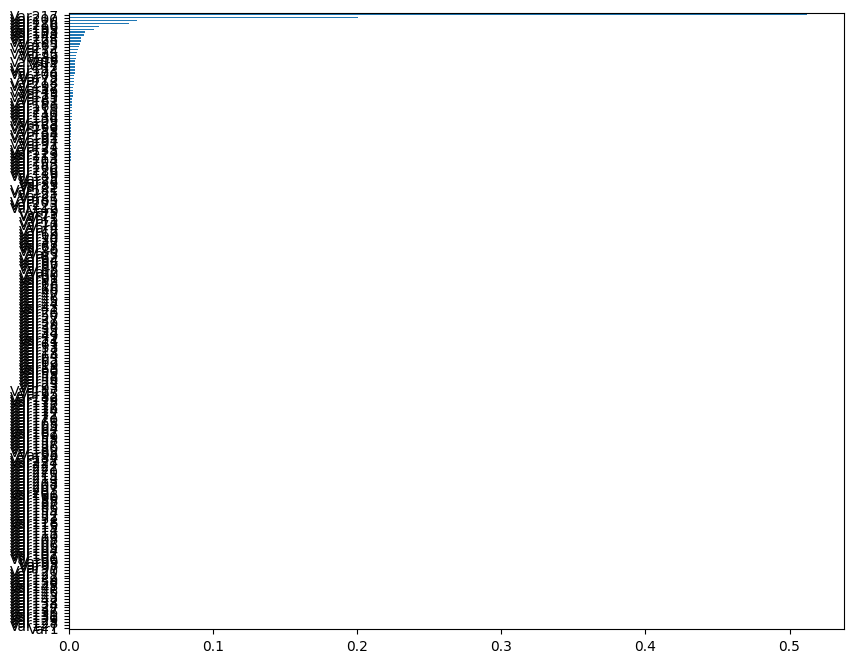

In [21]:
fi = calc_feature_importance_with_model(xgb.XGBClassifier(random_state=42, enable_categorical=True), xx, yy)

In [22]:
fi_df1 = pd.DataFrame({'feature_name': xx.columns,
                      'drop_09999999': fi})

In [23]:
fi_df2 = pd.DataFrame({'feature_name': xx.columns,
                      'drop_03': fi})

In [24]:
df_concat = pd.concat([fi_df1.set_index('feature_name'), fi_df2.set_index('feature_name')], axis=1, join='outer')

In [25]:
features = fi_df2.feature_name[fi_df2['drop_03'] > 0].tolist()
features, len(features)

(['Var6',
  'Var7',
  'Var13',
  'Var21',
  'Var22',
  'Var24',
  'Var25',
  'Var28',
  'Var38',
  'Var57',
  'Var65',
  'Var72',
  'Var73',
  'Var74',
  'Var76',
  'Var81',
  'Var83',
  'Var85',
  'Var89',
  'Var94',
  'Var103',
  'Var109',
  'Var112',
  'Var113',
  'Var119',
  'Var123',
  'Var125',
  'Var126',
  'Var132',
  'Var133',
  'Var134',
  'Var135',
  'Var140',
  'Var144',
  'Var149',
  'Var153',
  'Var160',
  'Var163',
  'Var166',
  'Var173',
  'Var181',
  'Var189',
  'Var191',
  'Var192',
  'Var193',
  'Var194',
  'Var195',
  'Var197',
  'Var198',
  'Var199',
  'Var200',
  'Var202',
  'Var204',
  'Var205',
  'Var206',
  'Var210',
  'Var211',
  'Var212',
  'Var216',
  'Var217',
  'Var218',
  'Var219',
  'Var223',
  'Var225',
  'Var226',
  'Var228',
  'Var229'],
 67)

Проаналізувавши отримані дані, отримали цікаві результати: виявляється, що ознака `Var200` із дуже високом відсотком пропусків (більше 50%) є дуже важливою.
Саме через це в нашому класі `DropColumns` з"явився `white_list`.

### 4. Побудова пайплайну.

На даному етапі у нас все готово для формування пайплайну і підбору гіперпараметрів.

In [26]:
nan_transformer = make_column_transformer(
        (make_pipeline(
                    SimpleImputer(strategy='constant', fill_value='__unknown_val__'),
                    TargetEncoder(random_state=42),
                ),
            make_column_selector(dtype_include=object)),
        (make_pipeline(
                    SimpleImputer(strategy='mean'),
                    StandardScaler(),
                ),
            make_column_selector(dtype_include=np.number)),
    )

pipeline = make_pipeline(
            DropColumns(),
            nan_transformer,
            SMOTE(random_state=42),
            xgb.XGBClassifier(enable_categorical=True, eval_metric='logloss'),
            verbose=True
        )

def model_fit_predict_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return balanced_accuracy_score(y_test, y_pred)

Випробуємо нашу побудовану пайпланй-модель в базовій конфігурації.

In [27]:
xy = load_train()
y = xy.y
x = xy.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,
                                                    random_state=42)

print(model_fit_predict_score(pipeline, X_train, X_test, y_train, y_test))

[Pipeline] ....... (step 1 of 4) Processing dropcolumns, total=   0.1s
[Pipeline] . (step 2 of 4) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 3 of 4) Processing smote, total=   0.1s
[Pipeline] ..... (step 4 of 4) Processing xgbclassifier, total=   1.8s
0.8965208140428298


Сформуємо список гіперпараметрів та їх діапазони, які ми хочемо "дотюнити".

In [28]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'dropcolumns', 'columntransformer', 'smote', 'xgbclassifier', 'dropcolumns__columns_to_drop', 'dropcolumns__threshold', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__pipeline-1', 'columntransformer__pipeline-2', 'columntransformer__pipeline-1__memory', 'columntransformer__pipeline-1__steps', 'columntransformer__pipeline-1__verbose', 'columntransformer__pipeline-1__simpleimputer', 'columntransformer__pipeline-1__targetencoder', 'columntransformer__pipeline-1__simpleimputer__add_indicator', 'columntransformer__pipeline-1__simpleimputer__copy', 'columntransformer__pipeline-1__simpleimputer__fill_value', 'columntransformer__pipeline-1__simpleimputer__keep_empty_features', 'colum

In [29]:
# params = {
#     'dropcolumns__threshold': [0.2, 0.3, 0.5, 0.6],
#     'smote__k_neighbors': [5,6,7,8,9],
#     'xgbclassifier__learning_rate': [0.1, 0.2, 0,3, 0.4],
#     'xgbclassifier__max_depth': [2,3,4,5,6,7],
#     'xgbclassifier__n_estimators': [50, 100, 150],
# }
#
# rs = RandomizedSearchCV(
# rs = GridSearchCV(
#             pipeline,
#             params,
#             scoring='balanced_accuracy',
#             n_jobs=-1,
#             refit=False,
#             random_state=42,
#             verbose=1
#         )

# search = rs.fit(x, y)
# search.best_params_

Задопомогою методів `RandomizedSearchCV` та `GridSearchCV` та мануальних маніпуляцій з діапазонами, було визначено набір гіперпараметрів.

In [30]:
params = {
    'dropcolumns__threshold': 0.3,
    'smote__k_neighbors': 7,
    'xgbclassifier__learning_rate': 0.1,
    'xgbclassifier__max_depth': 3,
    'xgbclassifier__n_estimators': 100
}

In [31]:
pipeline.set_params(**params)

Pipeline(steps=[('dropcolumns',
                 DropColumns(columns_to_drop=['Var18', 'Var33', 'Var56',
                                              'Var138', 'Var150', 'Var45',
                                              'Var39', 'Var179', 'Var194',
                                              'Var94', 'Var147', 'Var82',
                                              'Var34', 'Var86', 'Var159',
                                              'Var51', 'Var167', 'Var189',
                                              'Var184', 'Var52', 'Var155',
                                              'Var118', 'Var182', 'Var32',
                                              'Var43', 'Var67', 'Var139',
                                              'Var166', 'Var157', 'Var213', ...])),
                ('columntransformer',
                 Column...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

Порахуємо метрику на тренувальних даних із застосуванням крос-валідації.

### 5. Застосування моделі.

Порахуємо метрику на тренувальних даних задопомогою кросвалідації.

In [32]:
Xy = load_train()
y = Xy.y
x = Xy.drop('y', axis=1)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = cross_val_score(
                        estimator=pipeline,
                        X=x,
                        y=y,
                        scoring='balanced_accuracy',
                        cv=kf
                    )

cv_results, cv_results.mean()

[Pipeline] ....... (step 1 of 4) Processing dropcolumns, total=   0.1s
[Pipeline] . (step 2 of 4) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 3 of 4) Processing smote, total=   0.1s
[Pipeline] ..... (step 4 of 4) Processing xgbclassifier, total=   0.8s
[Pipeline] ....... (step 1 of 4) Processing dropcolumns, total=   0.1s
[Pipeline] . (step 2 of 4) Processing columntransformer, total=   0.6s
[Pipeline] ............. (step 3 of 4) Processing smote, total=   0.1s
[Pipeline] ..... (step 4 of 4) Processing xgbclassifier, total=   1.4s
[Pipeline] ....... (step 1 of 4) Processing dropcolumns, total=   0.1s
[Pipeline] . (step 2 of 4) Processing columntransformer, total=   0.7s
[Pipeline] ............. (step 3 of 4) Processing smote, total=   0.1s
[Pipeline] ..... (step 4 of 4) Processing xgbclassifier, total=   1.2s
[Pipeline] ....... (step 1 of 4) Processing dropcolumns, total=   0.1s
[Pipeline] . (step 2 of 4) Processing columntransformer, total=   0.5s
[Pipel

(array([0.89699381, 0.89244032, 0.83284704, 0.88642794, 0.87104332,
        0.88854874, 0.88039688, 0.87159497, 0.8650155 , 0.8813939 ]),
 0.8766702422253017)

Порахуємо передбачення для верифікаційного набору даних і запишемо у файл для відправки в Кагл.

In [33]:
# prepare submission
xy = load_train()
y = xy.y
x = xy.drop('y', axis=1)

pipeline.fit(x, y)

x_test = load_test()

y_pred = pipeline.predict(x_test)

write_submission(y_pred)

[Pipeline] ....... (step 1 of 4) Processing dropcolumns, total=   0.1s
[Pipeline] . (step 2 of 4) Processing columntransformer, total=   0.4s
[Pipeline] ............. (step 3 of 4) Processing smote, total=   0.1s
[Pipeline] ..... (step 4 of 4) Processing xgbclassifier, total=   1.1s


## Висновки.

Виконання фінального проекту додало більше впевненості у застосуванні методів і підходів засвоєних підчас проходження курсу "Основи машинного навчання".

Цікавим спостереженням виявилося те, що дуже часто ускладнення пайплайну, додавання додаткових етапів обробки даних призводило до зниження метрики.

Особливо важливо зауважити, що метрики отримані локально для вхідного набору даних (навіть з використанням кросвалідації) дуже відрізняються від метрик отриманих на публічному верифікаційному наборі.
І це додає великого дискомфорту. Адже покращення даних, використання різних моделей, підбір гіперпараметрів - все це може мати гарний результат на тренувальних даних, але кардинальне зменьшення метрики на Каглі, і навпаки - ненайкращі конфігурації можуть показати неймовірно гарну метрику на Каглі.
Я припускаю, що це пов"язано з тим, що характер пропусків в тренувальному наборі даних і в тестовому - дуже відрізняється.